In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pylab as py

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 120

import sys
import pickle as pkl
from Signal import *
sys.path.append("../DetResponse/")
sys.path.append("../Utils/")
from Detector import *
from Plot_Histogram import *

# KDE:
from KDEpy import FFTKDE
from KDEpy.bw_selection import improved_sheather_jones

In [2]:
def kde_FFT(x, x_grid, bandwidth=0.03, weights=None):
    if bandwidth=='ISJ':
        # Implementation of ISJ in >1D following discussion here:
        # https://github.com/tommyod/KDEpy/issues/81
        # dimension:
        n = x.shape[1]
        print('dimension: {}'.format(n))
        bw_array = np.zeros(n)
        for i in range(n):
            bw_array[i] = improved_sheather_jones(x[:, [i]], weights=weights)
        print('bandwidth: ')
        print(bw_array)    
        x_scaled = x/bw_array
        grid_scaled = x_grid/bw_array
        y_scaled = FFTKDE(bw=1).fit(x_scaled, weights=weights).evaluate(grid_scaled)
        y = y_scaled/np.prod(bw_array)
    elif bandwidth=='scott':
        # dimension:
        d = x.shape[1]
        # number of points:
        n = x.shape[0]
        print('dimension: {}'.format(d))
        print('length of the sample {}'.format(n))
        bw_scott = n**(-1./(d+4))
        print('bandwidth: {}'.format(bw_scott))
        y = FFTKDE(bw=bw_scott, kernel='gaussian').fit(x, weights=weights).evaluate(x_grid)
    else:    
        y = FFTKDE(bw=bandwidth, kernel='gaussian').fit(x, weights=weights).evaluate(x_grid)

    return y


# Mirror data at boundary 0
# bound: dictionary {dimension that bounded: bound value}
def MirroringData(data, bound):
    mirrordata = np.zeros(data.shape)
    for i in range(data.shape[0]):
        if i in bound:
            mirrordata[i] = 2*bound[i] - data[i]       
        else:
            mirrordata[i] = data[i]       
    return np.concatenate((data, mirrordata), axis=1)




In [3]:
# -----------------------------------------------------------
## FFT kde only use data point within the evaluation grids
## Thus I extend the grid to 1 more points for each dimension
## But these points will not be used
def Extend_EvalPoints(E_true, E_reco, maxEtrue, maxEreco, psi_true, psi_reco):
    # E true
    Etrue_width = E_true[1] - E_true[0]
    while E_true[-1]<maxEtrue:
        E_true = np.append(E_true, E_true[-1]+Etrue_width)
    while E_true[0]>0:    
        E_true = np.append(E_true[0]-Etrue_width, E_true)
        

    logEreco_width = np.log10(E_reco[1]) - np.log10(E_reco[0])
    while E_reco[-1]<maxEreco:
        E_reco = np.append(E_reco, pow(10, np.log10(E_reco[-1])+logEreco_width))
    while E_reco[0]>0.01:    
        E_reco = np.append(pow(10, np.log10(E_reco[0])-logEreco_width), E_reco)
    

    psitrue_width = psi_true[1] - psi_true[0]
    psi_true = np.append(psi_true[0]-psitrue_width, psi_true)
    psi_true = np.append(psi_true, psi_true[-1]+psitrue_width)

    psireco_width = psi_reco[1] - psi_reco[0]
    psi_reco = np.append(psi_reco[0]-psireco_width, psi_reco)
    psi_reco = np.append(psi_reco, psi_reco[-1]+psireco_width)

    return E_true, E_reco, psi_true, psi_reco


#------------------------------------------------------------
## Get the open angle from GC, psi from RA and DEC

def psi_f(RA,decl):
    return np.arccos(np.cos(np.pi/2.-(-29.*np.pi/180))*np.cos(np.pi/2.-decl)\
                      +np.sin(np.pi/2.-(-29.*np.pi/180))*np.sin(np.pi/2.-decl)*\
                       np.cos(RA-266.*np.pi/180))



In [4]:
def KDE_RespMatrix(MCcut, Bin, bw_method, maxEtrue=1000, maxEreco=2000, Scramble=False, mirror=False):

    #Evaluate points:
    print("Preparing evaluation grid") 
    ##Equal spacing in the final variables: reco Psi & log10(E_reco), true psi and true E
    trueEeval, recoEeval, truePsieval, recoPsieval = Extend_EvalPoints(Bin["true_energy_center"], Bin["reco_energy_center"], maxEtrue, maxEreco, Bin["true_psi_center"], Bin["reco_psi_center"])  

    g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                            recoPsieval, recoEeval, indexing='ij')                      
    psi_eval_true = g_psi_true.flatten()
    E_eval_true = g_energy_true.flatten()
    psi_eval_reco = g_psi_reco.flatten()
    E_eval_reco = g_energy_reco.flatten()

    ##Evaluate the KDE in log(Psi)-log10E
    # psiE_eval = np.vstack([np.log(psi_eval_true), E_eval_true, 
    #                     np.log(psi_eval_reco), np.log10(E_eval_reco)])
    psiE_eval = np.vstack([psi_eval_true, E_eval_true, 
            psi_eval_reco, np.log10(E_eval_reco)])
    # psiE_eval = np.vstack([psi_eval_true, E_eval_true, 
    #         psi_eval_reco, E_eval_reco])  


    # Separate MC by each channel nutype->PID:
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    # nu_types = ["nu_mu"]

    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}
    # PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    PID = [[0.,1.]]
    Resp = dict()
    pidbin = 0
    for pid in PID:
        print("Computing {} PID bin".format(pid))
        # Resp[pidbin] = dict()
        # pidbin += 1
        for nu_type in nu_types:
            print("----{}".format(nu_type))

            psireco=MCcut["psi_reco"]
            if Scramble:
                print("Scrambled Response matrix")
                RAreco = MCcut["RA_reco"]
                Decreco = MCcut["Dec_reco"]
                # Create scramble RA:
                RAreco_Scr = np.random.uniform(0,2.*np.pi, size=len(RAreco))
                # Get correct psi from scramble RA and original DEC
                psireco = np.rad2deg(psi_f(RAreco_Scr, Decreco))

            loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type]) & (MCcut["PID"]>=pid[0])
                            & (MCcut["PID"]<pid[1]) 
                            & (MCcut["E_reco"] < maxEreco)
                            & (MCcut["E_reco"] > np.min(Bin["reco_energy_center"]))
                            & (MCcut["E_true"] < maxEtrue)
                            & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                            # & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                            # & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                            # & (psireco < np.max(Bin["reco_psi_center"]))
                            # & (psireco > np.min(Bin["reco_psi_center"]))
                            )
        
            #Extract MC events: 
            #NOTE: input psi in deg!
            psitrue = MCcut["psi_true"][loc]
            Etrue = MCcut["E_true"][loc]
            psireco = psireco[loc]
            Ereco = MCcut["E_reco"][loc]
            w = MCcut["w"][loc]        


            print("Preparing train grid")    
            # psiE_train = np.vstack([np.log(psitrue), Etrue, np.log(psireco), np.log10(Ereco)])
            
            psiE_train = np.vstack([psitrue, Etrue, psireco, np.log10(Ereco)])

            if mirror:
                psiE_train=MirroringData(psiE_train, {0:0, 2:0})
                w=np.concatenate((w,w))
                print("Correct bias at boundary psi=0 using mirror data (reflection)")
                # extend grid point to contain the mirror data
                recoPsieval_width = recoPsieval[1] - recoPsieval[0]
                while recoPsieval[0]>-180.:
                    recoPsieval=np.append(recoPsieval[0]-recoPsieval_width, recoPsieval)
                
                truePsieval_width = truePsieval[1] - truePsieval[0]
                while truePsieval[0]>-180.:
                    truePsieval=np.append(truePsieval[0]-truePsieval_width, truePsieval)
                
                g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                                        recoPsieval, recoEeval, indexing='ij')                      
                psi_eval_true = g_psi_true.flatten()
                E_eval_true = g_energy_true.flatten()
                psi_eval_reco = g_psi_reco.flatten()
                E_eval_reco = g_energy_reco.flatten()

                psiE_eval = np.vstack([psi_eval_true, E_eval_true, 
                        psi_eval_reco, np.log10(E_eval_reco)]) 


            print("Evaluating KDE.....")    

            kde_w = kde_FFT(psiE_train.T, psiE_eval.T, bandwidth=bw_method, weights=w)
            #Needs to be divided by evaluation angle
            # kde_weight = kde_w.reshape(psi_eval_true.shape)
            # kde_weight = kde_w/(psi_eval_true * psi_eval_reco)
            kde_weight = kde_w
                                    
            # Fill into histogram:
            Psitrue_edges = Bin["true_psi_edges"]
            Etrue_edges = Bin["true_energy_edges"]
            Psireco_edges = Bin["reco_psi_edges"]
            Ereco_edges = Bin["reco_energy_edges"]

            H, edges = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
                                bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges),
                                weights=kde_weight)

            # N = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
            #                     bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges))
            # if np.min(N)==0:
            #     return 'There is an empty bin!!'                    
            # H = H/N[0]

            Resp[nu_type] = H/(np.sum(kde_weight))* (np.sum(w))
    return Resp      



In [5]:
def KDE_RespFunctions(MCcut, Bin, bw_method, maxEeval=1000):

    #Evaluate points:
    print("Preparing evaluation grid") 

    # 4D Resolution:

    # trueEeval = Bin["true_energy_center"]
    truePsieval = Bin["true_psi_center"]
    # recoEeval = Bin["reco_energy_center"]
    recoPsieval = Bin["reco_psi_center"]
    maxE = maxEeval
    trueEeval, recoEeval = Extend_EvalPoints(Bin["true_energy_center"], Bin["reco_energy_center"], maxE, maxE)  

    g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                            recoPsieval, recoEeval, indexing='ij')                      
    psi_eval_true = g_psi_true.flatten()
    E_eval_true = g_energy_true.flatten()
    psi_eval_reco = g_psi_reco.flatten()
    E_eval_reco = g_energy_reco.flatten()

    ##Evaluate the KDE in log(Psi)-log10E
    # psiE_eval = np.vstack([np.log(psi_eval_true), np.log(E_eval_true), 
    #                     np.log(psi_eval_reco), np.log10(E_eval_reco)])
    psiE_eval = np.vstack([psi_eval_true, E_eval_true, 
            psi_eval_reco, np.log10(E_eval_reco)]) 


    # 2D effective area:
    g2D_psi_true, g2D_energy_true = np.meshgrid(truePsieval, trueEeval, indexing='ij')                      
    psi_eval_true2D = g2D_psi_true.flatten()
    E_eval_true2D = g2D_energy_true.flatten()
    psiE_eval2D = np.vstack([psi_eval_true2D, E_eval_true2D]) 


    # Separate MC by each channel nutype->PID:
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    # nu_types = ["nu_mu"]

    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}
    # PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    PID = [[0.,1.]]
    Reso = dict()
    Eff = dict()
    pidbin = 0
    for pid in PID:
        print("Computing {} PID bin".format(pid))
        # Resp[pidbin] = dict()
        # pidbin += 1
        for nu_type in nu_types:
            print("----{}".format(nu_type))

            loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type]) & (MCcut["PID"]>=pid[0])
                            & (MCcut["PID"]<pid[1]) 
                            & (MCcut["E_reco"] < maxE)
                            & (MCcut["E_reco"] > np.min(Bin["reco_energy_center"]))
                            & (MCcut["E_true"] < maxE)
                            & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                            & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                            & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                            & (MCcut["psi_reco"] < np.max(Bin["reco_psi_center"]))
                            & (MCcut["psi_reco"] > np.min(Bin["reco_psi_center"]))
                            )
        
            #Extract MC events: 
            #NOTE: input psi in deg!
            psitrue = MCcut["psi_true"][loc]
            Etrue = MCcut["E_true"][loc]
            psireco = MCcut["psi_reco"][loc]
            Ereco = MCcut["E_reco"][loc]
            w = MCcut["w"][loc]
            
            print("Preparing train grid")    
            # psiE_train = np.vstack([np.log(psitrue), Etrue, np.log(psireco), np.log10(Ereco)])
            psiE_train = np.vstack([psitrue, Etrue, psireco, np.log10(Ereco)])
            # psiE_train = np.vstack([psitrue, Etrue, psireco, Ereco])                          
            print("Evaluating KDE on Resolution.....")    

            kde_w = kde_FFT(psiE_train.T, psiE_eval.T, bandwidth=bw_method)
            #Needs to be divided by evaluation angle
            # kde_weight = kde_w.reshape(psi_eval_true.shape)
            kde_weight = kde_w
              
                                    
            # Fill into histogram:
            Psitrue_edges = Bin["true_psi_edges"]
            Etrue_edges = Bin["true_energy_edges"]
            Psireco_edges = Bin["reco_psi_edges"]
            Ereco_edges = Bin["reco_energy_edges"]

            H, edges = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
                                bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges),
                                weights=kde_weight)

            print("Properly normalizing the Resolution.....")    
                    
            Reso_norm = np.zeros(H.shape)
            for iE in range(0, len(Etrue_edges)-1):
                for ipsi in range(0, len(Psitrue_edges)-1):
                    temp = H[ipsi, iE, 0:len(Psireco_edges)-1, 0:len(Ereco_edges)-1]
                    if np.sum(temp) == 0: 
                        print("warning no evt for this bin:")
                        print("iE {}, ipsi {}".format(iE, ipsi))
                        continue
                    for jE in range(0, len(Ereco_edges)-1):
                        for jpsi in range(0, len(Psireco_edges)-1):
                            Reso_norm[ipsi, iE, jpsi, jE] = H[ipsi, iE, jpsi, jE]/np.sum(temp)
            Reso[nu_type] = Reso_norm                    

            print("Evaluating KDE on Effective Area.....")
            psiE_train2D = np.vstack([psitrue, Etrue])
            kde_w = kde_FFT(psiE_train2D.T, psiE_eval2D.T, bandwidth=bw_method, weights=w)

            H, edges = np.histogramdd((psi_eval_true2D, E_eval_true2D),
                    bins = (Psitrue_edges, Etrue_edges),
                    weights=kde_w)
            Eff[nu_type] = H                  
        
    return Eff, Reso


In [6]:
MC = ExtractMC(['140000', '120000', '160000'])
# MC = ExtractMC(['141122', '121122', '161122'])

In [7]:
# mass: true binning depends on the DM mass
mass = 100

# Binning:
# E true
N_Etrue = 100
Etrue_center = np.array(np.linspace(1., mass, N_Etrue))
Ewidth = (mass-1.)/(N_Etrue-1.)
Etrue_edges = np.array([E - Ewidth/2. for E in Etrue_center])
Etrue_edges = np.append(Etrue_edges, Etrue_center[-1] + Ewidth/2.)
# Psi true
N_psitrue = 50
Psitrue_edges = np.linspace(0., 180., N_psitrue+1)
Psiwidth = 180./N_psitrue
Psitrue_center = np.array([Psitrue_edges[i]+Psiwidth/2. for i in range(len(Psitrue_edges)-1)])
# Psitrue_center = np.exp(np.linspace(np.log(0.005), np.log(180), 3* N_psitrue))

# E reco
Ereco_edges = pow(10., np.linspace(np.log10(1.), np.log10(1e3), 50+1))
Ereco_center = np.array([np.sqrt(Ereco_edges[i]*Ereco_edges[i+1]) for i in range(len(Ereco_edges) - 1)])


# Psi reco
N_psireco = 18
Psireco_edges = np.linspace(0., 180., N_psireco+1)
Psireco_center = np.array( [(Psireco_edges[i]+Psireco_edges[i+1])/2. for i in range(len(Psireco_edges)-1)] )
# Psireco_center = np.exp(np.linspace(np.log(0.005), np.log(180), 3* N_psireco))


# PID
PID_edges = np.array([0.,0.5,0.85,1.])
PID_center = np.array( [(PID_edges[i]+PID_edges[i+1])/2. for i in range(len(PID_edges)-1)] )

Bin = GroupBinning(Etrue_edges, Psitrue_edges, Etrue_center, Psitrue_center,
                Ereco_edges, Psireco_edges, Ereco_center, Psireco_center, PID_edges, PID_center)

In [8]:
Resp = KDE_RespMatrix(MC, Bin, 'ISJ', mirror=True, maxEtrue=100, maxEreco=1000)
# Resp = KDE_RespMatrix(MC, Bin, 0.03)
# Resp = KDE_RespMatrix(MC, Bin, 0.15, maxEeval=1000)


Preparing evaluation grid
Computing [0.0, 1.0] PID bin
----nu_e
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.24341219 0.04568916 0.25134899 0.00181752]
----nu_mu
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.21614442 0.04453665 0.26654898 0.00178881]
----nu_tau
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.3372583  0.04734049 0.32702225 0.00248393]
----nu_e_bar
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.20818784 0.05555418 0.21084678 0.00140318]
----nu_mu_bar
Preparing train grid
Correct bias at boundary psi=0 using mirror data (reflection)
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.19800079 0.0512881  0.20180627 0.0013387 ]
----nu_tau_bar
Pre

In [9]:
# Extract precompute spectra
channel = 'numunumu'
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
# pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl"


# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"

# Extract true rate:
# Jfactor:
Jfactor = Interpolate_Jfactor(pathJfactor, Psitrue_center)
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Etrue_center, channel, mass)

# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)

In [10]:
RecoRate = np.zeros((len(Psireco_center), len(Ereco_center)))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(Resp[nutype], Rate[nutype], axes=([0,1], [0,1]))
   


/tmp/ipykernel_4048/2725831255.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


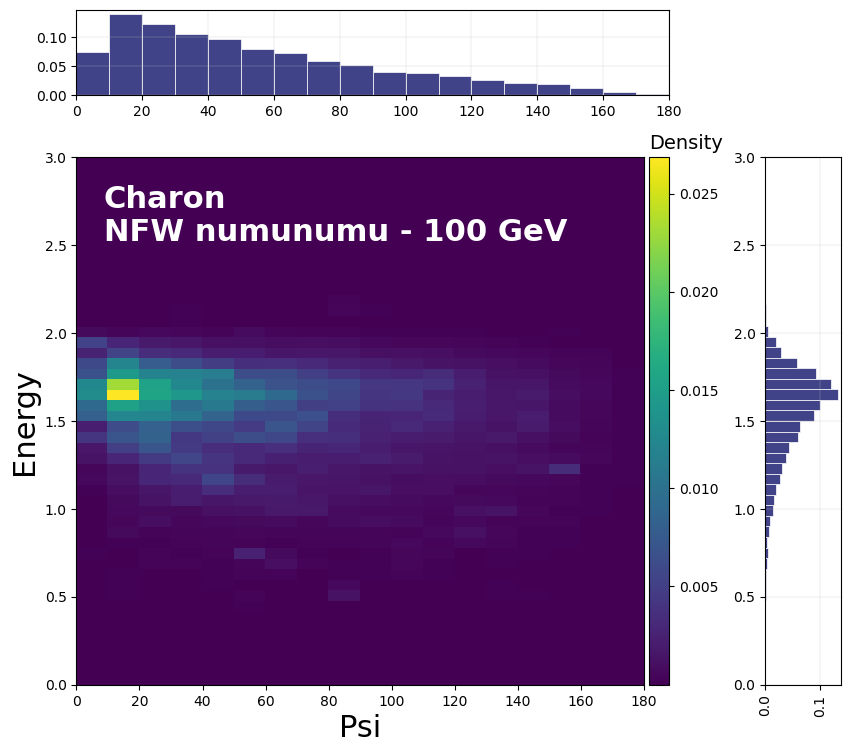

In [11]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon" "\n" "NFW {} - {} GeV".format(channel, mass))

In [31]:
# neutrino line with Scott bandwidth:
Resp = KDE_RespMatrix(MC, Bin, 'scott')


Preparing evaluation grid
Computing [0.0, 1.0] PID bin
----nu_e
Min max Etrue eval: 1.0 1000.6868686868779
Min max Ereco eval: 1.0715193052376064 1071.519305237606
Min max Etrue MC: 1.001712764148956 999.3810833746832
Min max Ereco MC: 1.0715775340795517 665.8603401184082
Min max psitrue eval: -1.8000000000000005 181.8
Min max psireco eval: -5.0 185.0
Min max psitrue MC: 0.10536823223439655 179.9292839450216
Min max psireco MC: 0.05614631186026175 179.97468259303804
Preparing train grid
Evaluating KDE.....
dimension: 4
length of the sample 926111
bandwidth: 0.1795424386270039
----nu_mu
Min max Etrue eval: 1.0 1000.6868686868779
Min max Ereco eval: 1.0715193052376064 1071.519305237606
Min max Etrue MC: 1.0001938109517197 999.8826459416011
Min max Ereco MC: 1.071717530488968 820.8517918586731
Min max psitrue eval: -1.8000000000000005 181.8
Min max psireco eval: -5.0 185.0
Min max psitrue MC: 0.11668636005234623 179.87797648879013
Min max psireco MC: 0.16199630625322042 179.94922218673923

In [32]:
RecoRate = np.zeros((len(Psireco_center), len(Ereco_center)))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(Resp[nutype], Rate[nutype], axes=([0,1], [0,1]))

/tmp/ipykernel_16395/2725831255.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon" "\n" "NFW {} - {} GeV".format(channel, mass))


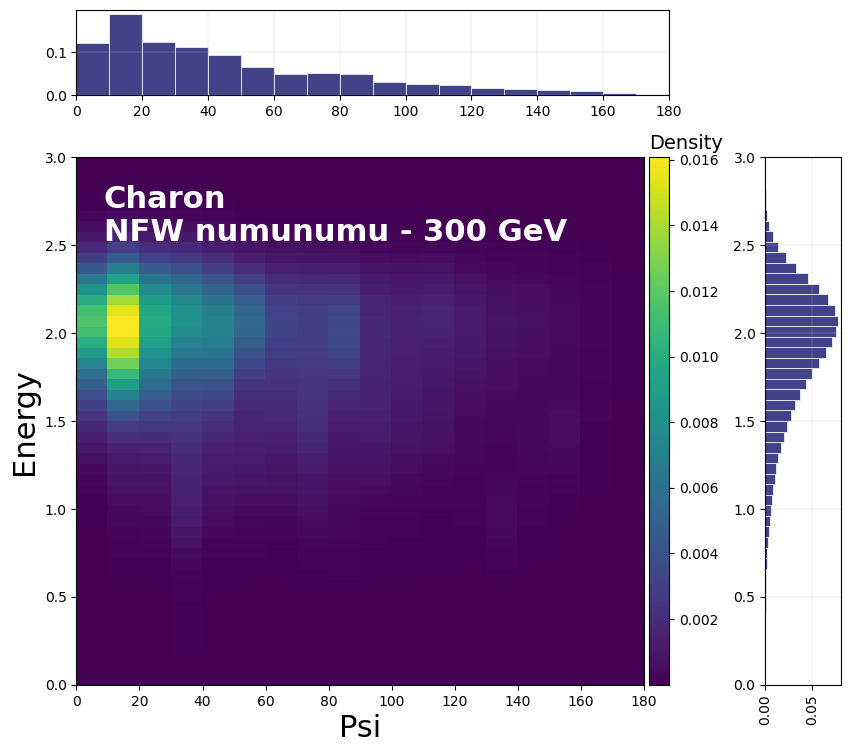

In [33]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon" "\n" "NFW {} - {} GeV".format(channel, mass))

Response Functions

In [29]:
Eff, Reso = KDE_RespFunctions(MC, Bin, 'ISJ', maxEeval=3000)

Preparing evaluation grid
Computing [0.0, 1.0] PID bin
----nu_e
Preparing train grid
Evaluating KDE on Resolution.....
dimension: 4
bandwidth: 
[1.032968   0.26792284 0.69242486 0.00561756]
Properly normalizing the Resolution.....
Evaluating KDE on Effective Area.....
dimension: 2
bandwidth: 
[0.02309141 0.39007311]
----nu_mu
Preparing train grid
Evaluating KDE on Resolution.....
dimension: 4
bandwidth: 
[0.83513115 0.22204497 0.50818156 0.00132903]
Properly normalizing the Resolution.....
Evaluating KDE on Effective Area.....
dimension: 2
bandwidth: 
[0.0245835  0.41353613]
----nu_tau
Preparing train grid
Evaluating KDE on Resolution.....
dimension: 4
bandwidth: 
[1.01134539 0.38497402 0.68837359 0.00562527]
Properly normalizing the Resolution.....
Evaluating KDE on Effective Area.....
dimension: 2
bandwidth: 
[0.03060863 0.5060084 ]
----nu_e_bar
Preparing train grid
Evaluating KDE on Resolution.....
dimension: 4
bandwidth: 
[1.31753421 0.29634977 0.91330208 0.00630349]
Properly norma

In [19]:
RecoRate = np.zeros((len(Psireco_center), len(Ereco_center)))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(Reso[nutype], Rate[nutype]* Eff[nutype], axes=([0,1], [0,1]))

In [18]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon" "\n" "NFW {} - {} GeV".format(channel, mass))

NameError: name 'RecoRate' is not defined

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


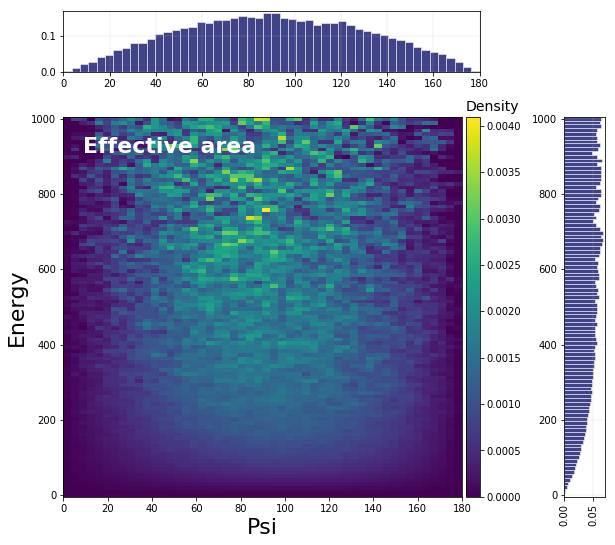

In [24]:
plot_projections(Eff['nu_mu'], np.array([Psitrue_edges, Etrue_edges]), "Psi", "Energy", "Effective area")

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


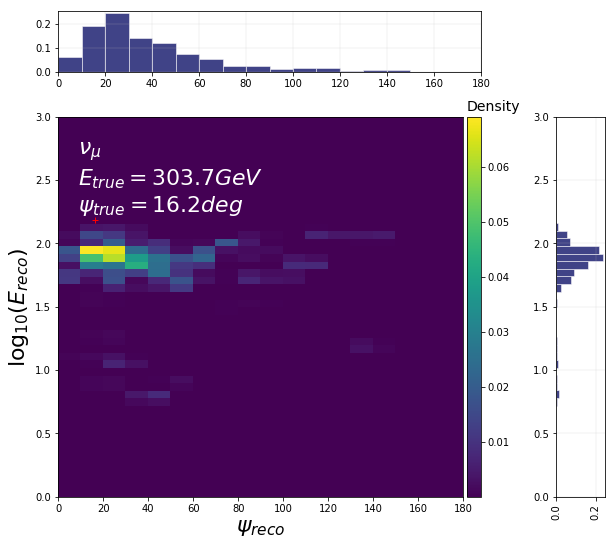

In [30]:
plot_Resolution(Reso['nu_e'][4, 15, 0:18, 0:50], Psitrue_center[4], np.log10(Etrue_center[15]) ,np.array([Psireco_edges, np.log10(Ereco_edges)]), r"$\psi_{reco}$", r"log$_{10}(E_{reco})$", 
            r"$\nu_\mu$" "\n" r"$E_{true}=303.7 GeV$" "\n" r"$\psi_{true}=16.2 deg$")

In [28]:
Reso['nu_e'].shape

(50, 100, 18, 50)

In [14]:
psi_reso = np.zeros((50, 18))
for i in range(50, 51):
    for j in range(0, 50):
        psi_reso += Reso['nu_mu'][0:50, i, 0:18, j]

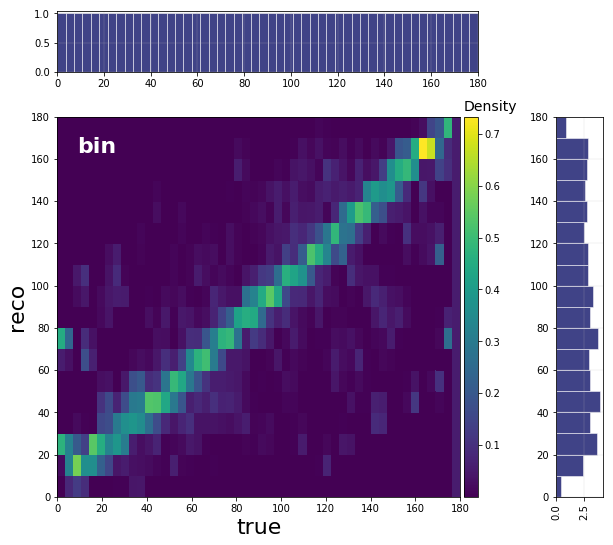

In [15]:
plot_projections(psi_reso, [Psitrue_edges, Psireco_edges], x_label='true', y_label='reco', title='bin')

In [16]:
E_kde = np.zeros((100, 50))
for i in range(0, 50):
    for j in range(0, 18):
        E_kde += Reso['nu_mu'][i, 0:100, j, 0:50]

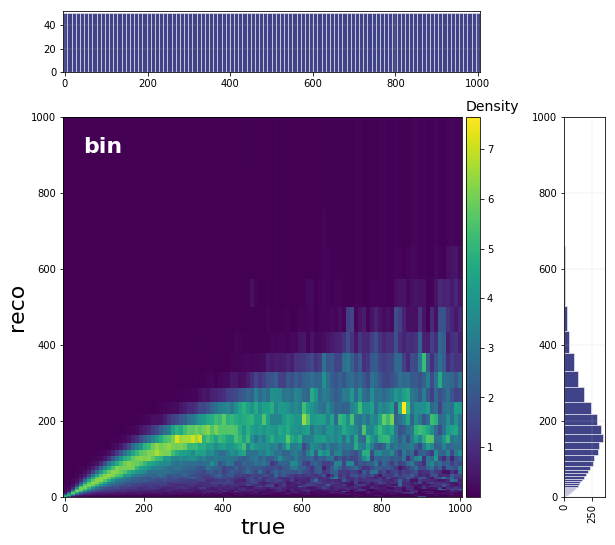

In [17]:
plot_projections(E_kde, [Etrue_edges, Ereco_edges], x_label='true', y_label='reco', title='bin')

# <font color="darkmagenta">Evt by Evt</font>

In [32]:
#---------------------------------------------------------------------
#Define cut on weight
#---------------------------------------------------------------------
def define_weightcut(weight, cut):
    
    H, edges = np.histogram(weight, bins=1000)
    zeroes = np.where(H==0.)
    
    #print (zeroes)
    
    i = 0
    n = 0

    while (i<zeroes[0].shape[0]-1) and (n<cut+1):
        
        #Check if consecutive zeroes
        if zeroes[0][i]+1 == zeroes[0][i+1]:
            n += 1
        #Reset n to zero if encounter non-nul value
        elif zeroes[0][i]+1 != zeroes[0][i+1]:
            #print ("Reset to zero")
            n = 0

        if n == cut:
            loc = zeroes[0][i]
            #print ("Location:", loc)
    
        i+=1
        
    if n >= cut:
        w_lim = edges[loc]
    else:
        w_lim = max(weight)
        
    return w_lim

# Compute weights and extract other informations used for evt-by-evt reweight:
def ComputeWeight(MCdict, SpectraPath, JfactorPath, channel, mass, maxE=2000, weight_cut=True):
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

    #PDF_variables
    array_recopsi = np.array([])
    array_recoE = np.array([])
    array_recoRA = np.array([])
    array_recoDec = np.array([])
    
    array_PID = np.array([])
    signal_w = np.array([])

    for nu_type in nu_types:
        loc = np.where( (MCdict["E_true"]<=mass) & (MCdict["nutype"]==pdg_encoding[nu_type]) & (MCdict["E_reco"]<=maxE) )
        if len(loc[0])==0: 
            continue
        ##Sort all variables by increasing true_E values##
        ##NOTE: this is required for spectra interpolation
        # sort = MCdict["E_true"][loc].argsort()

        ##Simulation weight##
        genie_w = MCdict["w"][loc]

        ##Spectra interpolation##
        true_E = MCdict["E_true"][loc]
        dNdE = Interpolate_Spectra(SpectraPath, true_E, channel, mass)

        ##Jfactor interpolation##
        #NOTE: input psi in deg!
        true_psi = MCdict["psi_true"][loc]
        Jpsi = Interpolate_Jfactor(JfactorPath, true_psi)

        ##Signal weight##
        weight = (1./(2 * 4*math.pi * mass**2)) * genie_w * dNdE[nu_type] * Jpsi

        ##Reco variables:
        reco_psi = MCdict["psi_reco"][loc]
        reco_E = MCdict["E_reco"][loc]
        reco_RA = MCdict["RA_reco"][loc]
        reco_Dec = MCdict["Dec_reco"][loc]
        PID = MCdict["PID"][loc]

        ## perform cuts on weight
        if weight_cut == "True":
            w_lim = define_weightcut(weight, 200) #Previously 200
            print ("##Applying cut on weight##")
            print ("Weight lim:", w_lim)
            w_loc = np.where(weight<=w_lim)
            #Renormalise weight for total weight to be unchanged
            weight = weight[w_loc] * (sum_w/np.sum(weight[w_loc]))
            true_psi = true_psi[w_loc]
            true_E = true_E[w_loc]
            reco_psi = reco_psi[w_loc]
            reco_E = reco_E[w_loc]
            reco_RA = reco_RA[w_loc]
            reco_Dec = reco_Dec[w_loc]
            PID = PID[w_loc] 


        ##group all nutype:
        array_recopsi = np.append(array_recopsi, reco_psi)
        array_recoE = np.append(array_recoE, reco_E)
        array_PID = np.append(array_PID, PID)
        array_recoRA = np.append(array_recoRA, reco_RA)
        array_recoDec = np.append(array_recoDec, reco_Dec)
        signal_w = np.append(signal_w, weight)
    return array_PID, array_recopsi, array_recoE, signal_w, array_recoRA, array_recoDec

def KDE_evtbyevt(MCdict, SpectraPath, JfactorPath, channel, mass, bw_method, Bin, Scramble=False, weight_cut=True, mirror=False):
    array_PID, array_recopsi, array_recoE, signal_w, array_recoRA, array_recoDec = ComputeWeight(MCdict, SpectraPath, JfactorPath, channel, mass, weight_cut=weight_cut)
    # Define PID cut:
    # PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    PID = [[0, 1]]


    #Evaluate points:
    print("Preparing evaluation grid") 
    ##Equal spacing in the final variables: reco Psi & log10(E), true psi and true E
    maxE = 2000.
    trueEeval, recoEeval, truePsieval, recoPsieval = Extend_EvalPoints(Bin["true_energy_center"], Bin["reco_energy_center"], maxE, maxE, Bin["true_psi_center"], Bin["reco_psi_center"])  

    g_psi_reco, g_energy_reco = np.meshgrid(recoPsieval, recoEeval, indexing='ij')                      
    psi_eval_reco = g_psi_reco.flatten()
    E_eval_reco = g_energy_reco.flatten()

    ##Evaluate the KDE in log(Psi)-log10E
    # psiE_eval = np.vstack([np.log(psi_eval_true), E_eval_true, 
    #                     np.log(psi_eval_reco), np.log10(E_eval_reco)])
    psiE_eval = np.vstack([psi_eval_reco, np.log10(E_eval_reco)])

    # pdf = np.zeros((len(PID),len(Psireco_edges)-1, len(Ereco_edges)-1))
    # i = 0
    # sum = 0
    for pidbin in PID:
        print("Computing {} PID bin".format(pidbin))
            
        loc = np.where( ( array_PID >= pidbin[0]) & ( array_PID <= pidbin[1]) 
                            & (array_recoE < maxE)
                            & (array_recoE > np.min(Bin["reco_energy_center"]))
                        )
                   
        #PDF_variables
        recopsi = array_recopsi[loc]
        if Scramble:
            print("Buid Scramble PDF--------")
            RAreco = array_recoRA[loc]
            Decreco = array_recoDec[loc]
            # Create scramble RA:
            RAreco_Scr = np.random.uniform(0,2.*np.pi, size=len(RAreco))
            # Get correct psi from scramble RA and original DEC
            recopsi = np.rad2deg(psi_f(RAreco_Scr, Decreco))
            
        recoE = array_recoE[loc]
        weight = signal_w[loc]

        psiE_train = np.vstack([recopsi,np.log10(recoE)])
        print(psiE_train.shape)
        if mirror:
            psiE_train=MirroringData(psiE_train, {0:0})
            weight=np.concatenate((weight,weight))
            print("Correct bias at boundary psi=0 using mirror data method")
            # extend grid point to contain the mirror data
            recoPsieval_width = recoPsieval[1] - recoPsieval[0]
            while recoPsieval[0]>-180.:
                recoPsieval=np.append(recoPsieval[0]-recoPsieval_width, recoPsieval)
            
            g_psi_reco, g_energy_reco = np.meshgrid(recoPsieval, recoEeval, indexing='ij')                      
            psi_eval_reco = g_psi_reco.flatten()
            E_eval_reco = g_energy_reco.flatten()
            psiE_eval = np.vstack([psi_eval_reco, np.log10(E_eval_reco)])    

        ##Evaluate KDE##
        #In terms of log(psi)-log10(E)
        kde_w = kde_FFT(psiE_train.T, psiE_eval.T
                        ,bandwidth=bw_method
                            ,weights=weight)
        kde_weight = kde_w                

        # Fill into histogram:
        Psireco_edges = Bin["reco_psi_edges"]
        Ereco_edges = Bin["reco_energy_edges"]
        H, v0_edges, v1_edges = np.histogram2d(psi_eval_reco, E_eval_reco,
                                            bins = (Psireco_edges, Ereco_edges),
                                            weights=kde_weight)

    return H

In [33]:
MC = ExtractMC(['140000', '120000', '160000'])
# MC = ExtractMC(['141122', '121122', '161122'])
mass = 200
# mass = 600

Bin = Std_Binning(mass)

# Extract precompute spectra
channel = 'numunumu'
# channel = 'bb'

pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
# pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl"

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"

In [34]:
PDF_evtbyevt = KDE_evtbyevt(MC, pathSpectra, pathJfactor, channel, mass, 'ISJ', Bin, mirror=True)

Preparing evaluation grid
Computing [0, 1] PID bin
(2, 5600465)
Correct bias at boundary psi=0 using mirror data method
dimension: 2
bandwidth: 
[0.02423974 0.00021551]


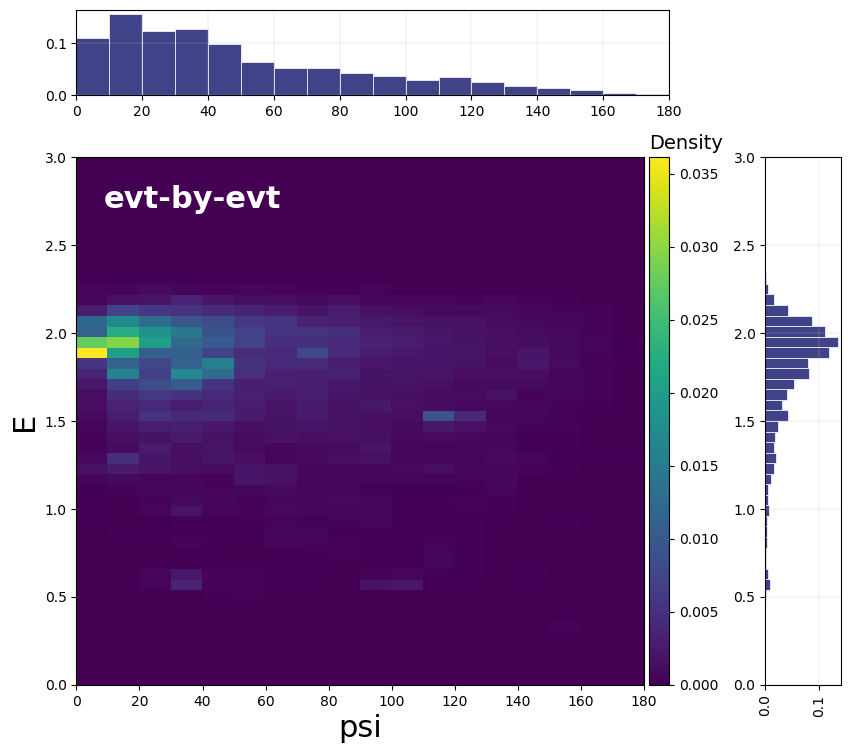

In [35]:
plot_projections(PDF_evtbyevt/np.sum(PDF_evtbyevt), [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], x_label='psi', y_label='E', title='evt-by-evt')

Scramble PDF

In [16]:
channel = "bb"
mass = 600
Bin = Std_Binning(mass)
MC = ExtractMC(['140000', '120000', '160000'])
# MC = ExtractMC(['141122', '121122', '161122'])
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
# pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl"

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"

In [69]:
PDF_evtbyevt = KDE_evtbyevt(MC, pathSpectra, pathJfactor, channel, mass, 'ISJ', Bin, Scramble=True)

Preparing evaluation grid
Computing [0, 1] PID bin
Buid Scramble PDF--------
(2, 5142008)
dimension: 2
bandwidth: 
[0.03277453 0.00063822]


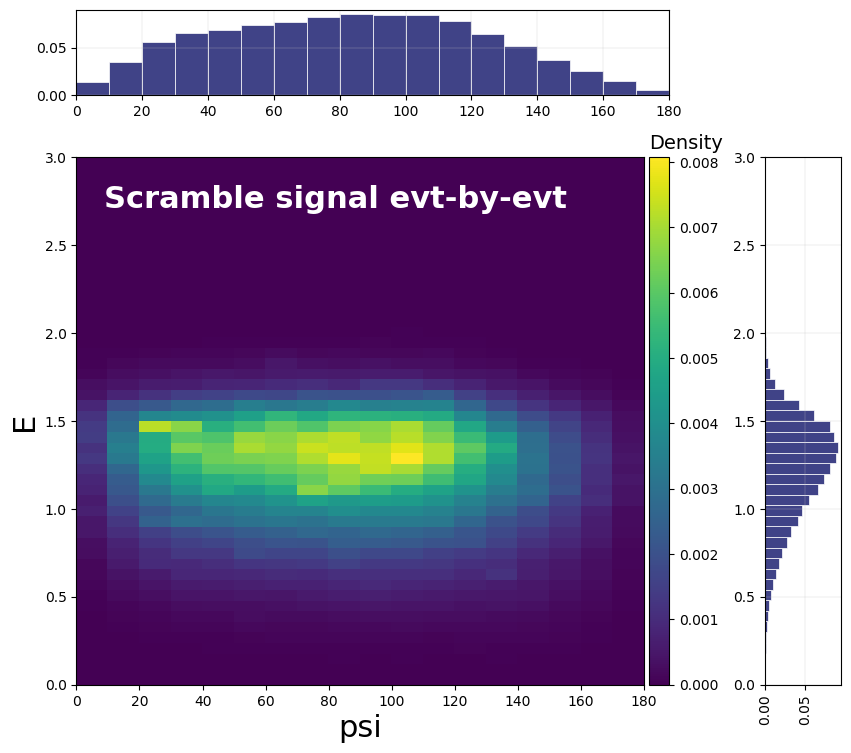

In [71]:
plot_projections(PDF_evtbyevt/np.sum(PDF_evtbyevt), [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], x_label='psi', y_label='E', title='Scramble signal evt-by-evt')

In [17]:
Resp = KDE_RespMatrix(MC, Bin, 'ISJ', Scramble=True)


Preparing evaluation grid
Computing [0.0, 1.0] PID bin
----nu_e
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.03679883 0.21104187 0.03889712 0.00063477]
----nu_mu
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.0398387  0.2156414  0.03927699 0.00069935]
----nu_tau
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.05003197 0.25899344 0.04690535 0.00079485]
----nu_e_bar
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.03669702 0.2059148  0.03712412 0.00062493]
----nu_mu_bar
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.038622   0.22342367 0.03920112 0.00065229]
----nu_tau_bar
Scrambled Response matrix
Preparing train grid
Evaluating KDE.....
dimension: 4
bandwidth: 
[0.05043748 0.26246292 0.04993975 0.00073993]


In [18]:
# Extract true rate:
# Jfactor:
Jfactor = Interpolate_Jfactor(pathJfactor, Psitrue_center)
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Etrue_center, channel, mass)

# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)

RecoRate = np.zeros((len(Psireco_center), len(Ereco_center)))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    RecoRate += np.tensordot(Resp[nutype], Rate[nutype], axes=([0,1], [0,1]))

/tmp/ipykernel_29514/3465251649.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon - Scrambled" "\n" "NFW {} - {} GeV".format(channel, mass))


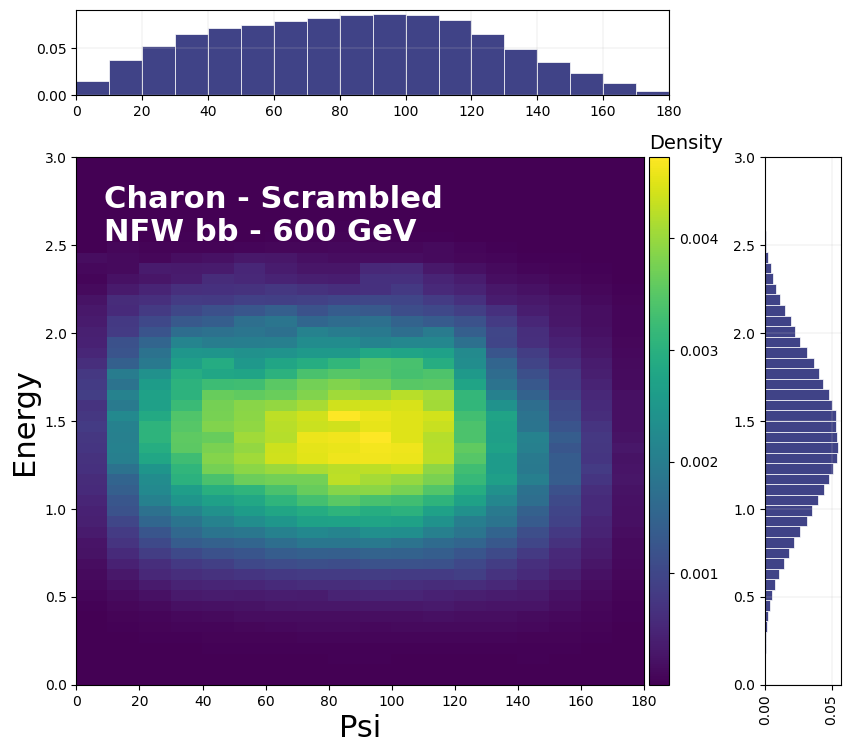

In [19]:
plot_projections(RecoRate/np.sum(RecoRate), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Charon - Scrambled" "\n" "NFW {} - {} GeV".format(channel, mass))

In [5]:
dat_dir = "/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/"
input_files = []
# Take all burnsample:
for year in range(2012, 2021):
    infile = dat_dir + "OscNext_Level7_v02.00_burnsample_{}_pass2_variables_NoCut.pkl".format(year)
    print('Loading file: ')
    print(infile)
    print('')
    dat = pkl.load(open(infile, 'rb'))
    input_files = np.append(input_files, dat['burnsample'])

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2012_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2013_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2014_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2015_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2016_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2017_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscN

(36670,)

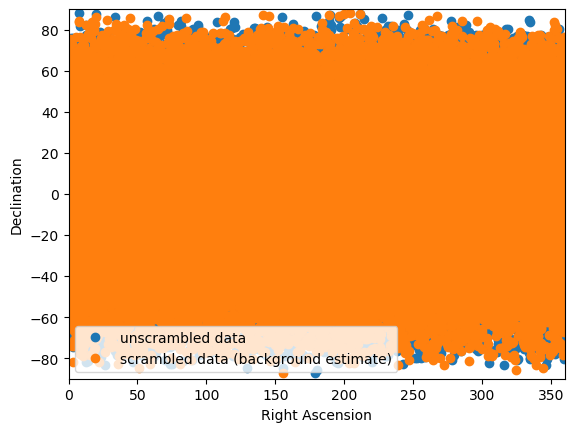

In [6]:
array_PID = np.array([])
array_recopsi = np.array([])
array_recopsi_original = np.array([])
array_recoE = np.array([])
array_recoRA = np.array([])
array_recoRA_original = np.array([])
array_recoDec = np.array([])

# input_file = data['burnsample']
for input_file in input_files:
# define cut:
    loc = np.where((input_file["L7muon_classifier_up"]>0.4) &
                    (input_file["L4noise_classifier"]>0.95) &
                    (input_file["L7reco_vertex_z"]>-500.) &
                    (input_file["L7reco_vertex_z"]<-200.) &
                    (input_file["L7reco_vertex_rho36"]<300.) &
                    (input_file["L5nHit_DOMs"]>2.5) &
                    (input_file["L7_ntop15"]<2.5) &
                    (input_file["L7_nouter"]<7.5) &
                    (input_file["L7reco_time"]<14500.))

    array_PID = np.append(array_PID, input_file["PID"][loc])
    array_recopsi_original = np.append(array_recopsi_original, input_file["reco_psi"][loc])
    array_recoE = np.append(array_recoE, input_file["reco_TotalEnergy"][loc])
    array_recoDec = np.append(array_recoDec, input_file["reco_Dec"][loc])
    array_recoRA_original = np.append(array_recoRA_original, input_file["reco_RA"][loc])

# Create scramble RA:
array_recoRA = np.random.uniform(0,2.*np.pi, size=len(array_recoRA_original))


# Draw sample scramble vs unscramble

plt.plot(np.degrees(array_recoRA_original), np.degrees(array_recoDec), 'o', color='tab:blue', label='unscrambled data')

plt.plot(np.degrees(array_recoRA), np.degrees(array_recoDec), 'o', color='tab:orange', label='scrambled data (background estimate)')

plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.legend(loc=0)

def psi_f(RA,decl):
    return np.arccos(np.cos(np.pi/2.-(-29.*np.pi/180))*np.cos(np.pi/2.-decl)\
                      +np.sin(np.pi/2.-(-29.*np.pi/180))*np.sin(np.pi/2.-decl)*\
                       np.cos(RA-266.*np.pi/180))

# Getting scramble RA psi:
array_recopsi = np.rad2deg(psi_f(array_recoRA, array_recoDec))

array_recoRA.shape
array_recoE.shape
# array_recopsi.shape

In [7]:
psiEtrain = np.vstack([array_recopsi, np.log10(array_recoE)])



In [8]:
Bin = Std_Binning(1000)

trueEeval, recoEeval, truePsieval, recoPsieval = Extend_EvalPoints(Bin["true_energy_center"], Bin["reco_energy_center"], np.max(array_recoE), np.max(array_recoE), Bin["true_psi_center"], Bin["reco_psi_center"])  
g_psi_reco, g_energy_reco = np.meshgrid(recoPsieval, recoEeval, indexing='ij')                      
psi_eval_reco = g_psi_reco.flatten()
E_eval_reco = g_energy_reco.flatten()
psiE_eval = np.vstack([psi_eval_reco, np.log10(E_eval_reco)])


In [9]:
print("{}, {}".format(np.min(array_recopsi), np.max(array_recopsi)))
print("{}, {}".format(np.min(psi_eval_reco), np.max(psi_eval_reco)))
print("{}, {}".format(np.min(array_recoE), np.max(array_recoE)))
print("{}, {}".format(np.min(recoEeval), np.max(recoEeval)))



0.7382862157948595, 179.30391347455665
-5.0, 185.0
0.015893686562776566, 544.9825096130371
0.009772372209558072, 933.254300796991


In [22]:
kde_w = kde_FFT(psiEtrain.T, psiE_eval.T
                ,bandwidth='ISJ')

dimension: 2
bandwidth: 
[2.33873418 0.01570578]


In [23]:
Psireco_edges = Bin["reco_psi_edges"]
Ereco_edges = Bin["reco_energy_edges"]
H, v0_edges, v1_edges = np.histogram2d(psi_eval_reco, E_eval_reco,
                                    bins = (Psireco_edges, Ereco_edges),
                                    weights=kde_w)


/tmp/ipykernel_1430/78504957.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(H/np.sum(H), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Scrambled Data")


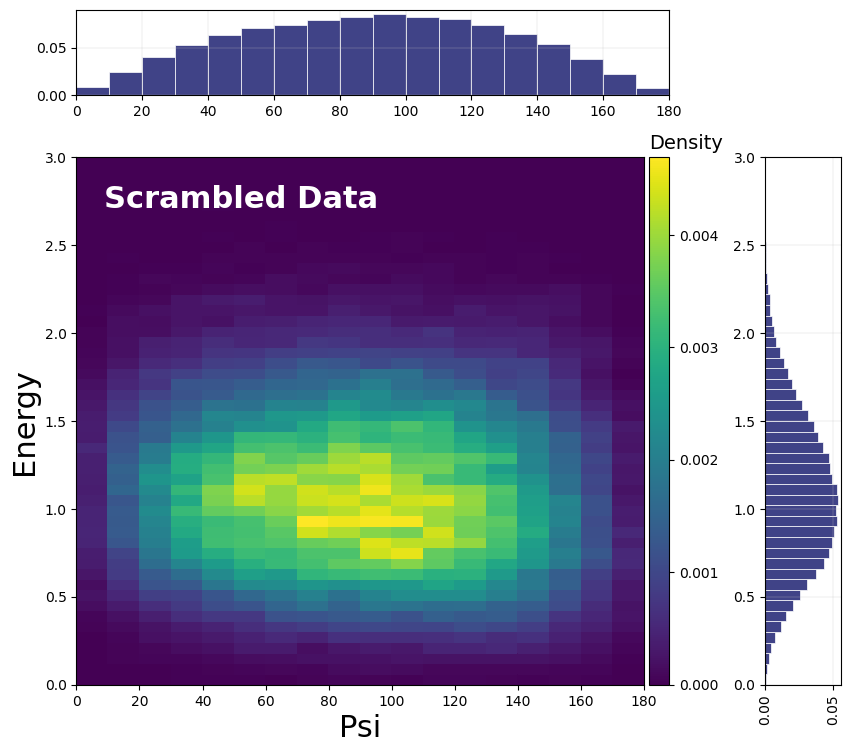

In [24]:
plot_projections(H/np.sum(H), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Scrambled Data")

/tmp/ipykernel_1430/374282424.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(H/np.sum(H), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Scrambled Data")


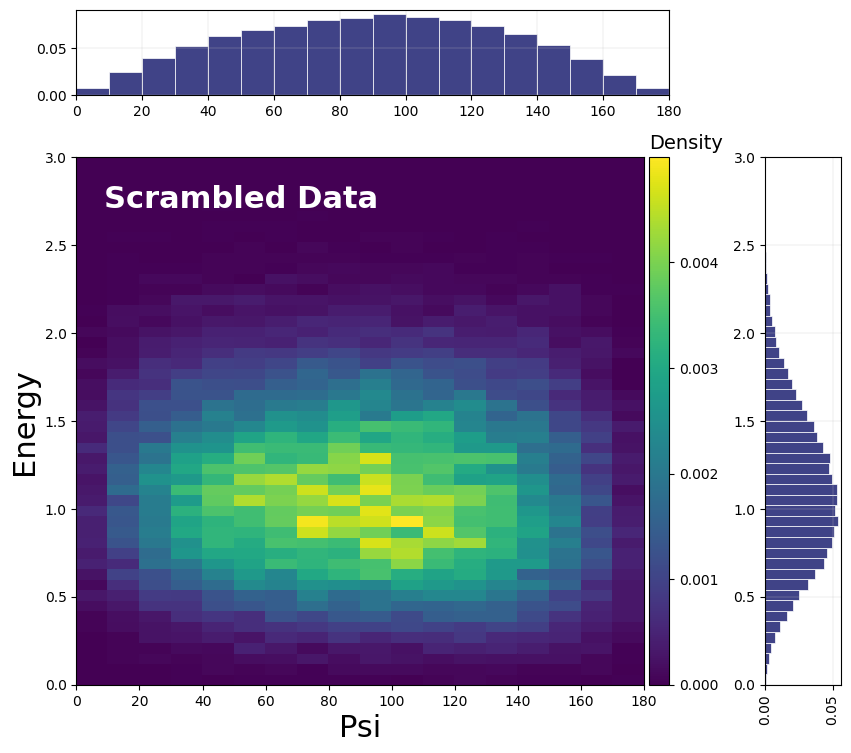

In [28]:
H, v0_edges, v1_edges = np.histogram2d(array_recopsi, array_recoE,
                                    bins = (Psireco_edges, Ereco_edges))
plot_projections(H/np.sum(H), np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "Scrambled Data")
